In [1]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf
from point_grid import *

In [ ]:
# Sanity testing polygon dataset. The means of all the columns should form a regular polygon. it does :)
df = pd.read_csv('data/6-gon-correct-procrustes.csv')

df = df[df.internal_nodes == 2.0].dropna(axis=1, how='all')
df = df[df.target_edge_length == 0.4]
df = df.drop(['target_edge_length', 'internal_nodes'], axis=1)
means = df.mean()
x = [means[0], means[2], means[4], means[6], means[8], means[10]]
y = [means[1], means[3], means[5], means[7], means[9], means[11]]

plt.plot(x, y)
plt.gca().set_aspect('equal')
pp.plot_polygon(pp.create_regular_ngon(6))
x, y


# Prediction pipeline for case: 6-gon with two internal nodes


In [2]:

def predict_internal_node_count() -> int:
    return 2


# Pre-processing method for nn2. 
def prediction_pipeline_nn2(contour, internal_node_count, grid_model: tf.keras.models.Model):

    # Predict internal node count using neural network 1.
    internal_node_count = predict_internal_node_count()

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour_data, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = grid_model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid


def direct_prediction_pipeline(contour_input_2, direct_model: tf.keras.models.Model):
    # Pre-process contour with procrustes superimposition
    transformed_contour_data = [coordinate for point in contour_input_2 for coordinate in point]

    # Define prediction data
    features = transformed_contour_data
    direct_prediction_data = np.expand_dims(features, axis=0)

    # Predict
    direct_prediction_result = direct_model(direct_prediction_data).numpy()

    return direct_prediction_result

# =======================
#     Initialization
# =======================
import gmsh

grid_model_path = 'model/thesis-grid-8gon-3int-gh'
direct_model_path = 'model/direct-internal-nodes-correct'
gmsh.initialize()
direct_model = tf.keras.models.load_model(direct_model_path)
grid_model = tf.keras.models.load_model(grid_model_path)

# Naive way of only checking the results on contours that the reference mesher would insert two points into
meshed_internal_node_count = -1
internal_node_count = predict_internal_node_count()

while meshed_internal_node_count != 3:
    contour = pp.create_random_ngon(8)
    transformed_contour = pp.procrustes(contour)['transformed_contour']

    meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
    meshed_internal_points = meshed_contour[-4:]
    meshed_internal_node_count = int(meshed_contour[13])
    print(f"meshed contour has {meshed_contour[13]} internal nodes!")
gmsh.finalize()

# Grid point prediction
predicted_point_grid = prediction_pipeline_nn2(transformed_contour, internal_node_count, grid_model)
pg_internal_nodes = generate_internal_nodes_from_grid_score(predicted_point_grid, internal_node_count)

# Direct prediction without point grid
predicted_internal_nodes = direct_prediction_pipeline(contour, direct_model)[0]


"""
|-------------------------
|       PLOTTING
|-------------------------
"""
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
# plt.grid(b=True)
pl0 = plt.plot([meshed_internal_points[0], meshed_internal_points[2]], 
         [meshed_internal_points[1], meshed_internal_points[3]], 'gD',
            label="Reference",
            )
pl2 = plt.plot([predicted_internal_nodes[0], predicted_internal_nodes[2]], 
               [predicted_internal_nodes[1], predicted_internal_nodes[3]], 
               'bo',
               label="Direct prediction"
)
pl1 = plt.plot([x[0] for x in pg_internal_nodes], [y[1] for y in pg_internal_nodes], 'rx', label="Patch prediction")
# Plot transformed contour
pl3 = pp.plot_polygon(transformed_contour, style='k')

# Plot point grid
pl4 = plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar(label="Grid point score")
plt.legend(loc='upper right', shadow='true')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
transformed_contour

meshed contour has 4.0 internal nodes!
meshed contour has 1.0 internal nodes!
meshed contour has 0.0 internal nodes!
meshed contour has 2.0 internal nodes!


ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis 1 of input shape to have value 24 but received input with shape (1, 20)

array([[ 0.45452194,  0.03645398],
       [ 0.58755646,  0.62112246],
       [-0.73326173,  0.68609644],
       [-0.81195797,  0.40939462],
       [-0.32689742, -0.72004376],
       [ 0.83003873, -1.03302373]])

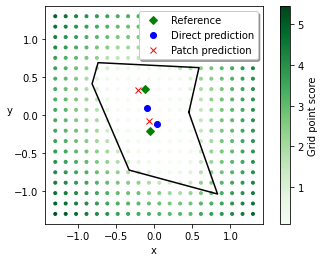

In [12]:
# Plot predicted points (green)
# plt.grid(b=True)
pl0 = plt.plot([meshed_internal_points[0], meshed_internal_points[2]], 
         [meshed_internal_points[1], meshed_internal_points[3]], 'gD',
            label="Reference",
            )
pl2 = plt.plot([predicted_internal_nodes[0], predicted_internal_nodes[2]], 
               [predicted_internal_nodes[1], predicted_internal_nodes[3]], 
               'bo',
               label="Direct prediction"
)
pl1 = plt.plot([x[0] for x in pg_internal_nodes], [y[1] for y in pg_internal_nodes], 'rx', label="Patch prediction")
# Plot transformed contour
pl3 = pp.plot_polygon(transformed_contour, style='k')

# Plot point grid
pl4 = plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar(label="Grid point score")
plt.legend(loc='upper right', shadow='true')
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.gca().set_aspect('equal')
transformed_contour

In [ ]:
# Try to scatter plot grid points to see whats going on
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')
plt.plot(meshed_internal_points[0], meshed_internal_points[1], 'gD')
plt.plot(meshed_internal_points[2], meshed_internal_points[3], 'gD')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')



In [ ]:
# Test data
point_grid_test = generate_point_grid()
test_points = [(-0.234, -0.234), (0.234, 0.234)]
transformed_contour = pp.procrustes(pp.create_random_ngon(6))['transformed_contour']
calculate_score(point_grid_test, test_points, transformed_contour)

internal_nodes = generate_internal_nodes_from_grid_score(point_grid_test, len(test_points))

# Try to scatter plot grid points to see whats going on
flat_pgp = [point for row in point_grid_test for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in test_points], [y[1] for y in test_points], 'gD')
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')



# Creating dataset for patches

In [ ]:
# 1. Read meshed contours to dataframe
df = pd.read_csv('data/6-gon-correct-procrustes.csv')

# Csv-file to write to.
new_csv_path = "data/patch-data-correct-procrustes.csv"

# 2. Separate based on internal nodes added. We choose 2 as it has the highest incidence.
#    -> Remove empty columns with dropna.
#    -> Remove target_edge_length column (experiment)
df = df[df.internal_nodes == 2.0].dropna(axis=1, how='all')
dataset = df[df.target_edge_length == 0.4]
dataset = dataset.drop(['target_edge_length', 'internal_nodes'], axis=1)

write_patch_collection_to_csv(generate_patch_collection(dataset), new_csv_path)


# Neural network 2: predicting internal node positions (or rather: predict grid score)

For now we only train the network on the dataset with:
- 6 edges
- 2 internal nodes
- 100 2x2 patches


In [ ]:
# ======================
#        DATASET 
# ======================
import pandas as pd

hexagon_path = "data/6-gon-correct-procrustes.csv"
patch_path = 'data/patch-data-correct-procrustes.csv'
dataset = pd.read_csv(patch_path)

# Split dataset into 70/15/15 training/validation/test
patch_train = dataset.sample(frac=0.85)
patch_test = dataset.drop(patches_train.index)

# Split dataset into features and labels; last 4 columns 
train_features = patch_train.iloc[:, :-4]
train_labels = patch_train.iloc[:, -4:]

test_features = patch_test.iloc[:, :-4]
test_labels = patch_test.iloc[:, -4:]

dataset.shape[0]

In [ ]:
# packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# ======================
#       MODEL STUFF
# ======================
INITIAL_LEARNING_RATE = 1e-3
EPOCHS = 1000
BATCH_SIZE = 512

model_path = 'model/thesis-grid-1'

def grid_model_setup():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(20,)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(4),
    ])

    return model

model = grid_model_setup()
model.summary()

decay_steps= 10_000
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, decay_steps, 1e-3)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(
                  learning_rate=lr_schedule,
              ),
              )

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=EPOCHS//5, min_delta=0.0001)


history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    callbacks=[checkpoint, early_stopping],
                    )

# ======================
#       EVALUATION
# ======================
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))


In [ ]:
# ======================
#  EVALUATE SAVED MODEL 
# ======================

saved_model = tf.keras.models.load_model('model/thesis-grid-1')

train_acc = saved_model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = saved_model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.ylim(0.13, 0.25)

# Stat gathering for nn2

1. Create random contour.
2. Find internal mesh points with gmsh, grid nn and direct nn.
3. Calculate how often grid/direct is outside, and the mean euclidean error.

In [ ]:
grid_model_path = 'model/thesis-grid-1'
direct_model_path = 'model/direct-internal-nodes-correct'


# Pre-processing method for nn2. 
def stat_prediction_pipeline_nn2(contour, internal_node_count, grid_model):

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour_data, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = grid_model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid


def stat_direct_prediction_pipeline(contour_input_2, direct_model):
    # Pre-process contour with procrustes superimposition
    transformed_contour_data = [coordinate for point in contour_input_2 for coordinate in point]

    # Load model
    

    # Define prediction data
    features = transformed_contour_data
    direct_prediction_data = np.expand_dims(features, axis=0)

    # Predict
    direct_prediction_result = direct_model(direct_prediction_data).numpy()

    return direct_prediction_result


def calc_squared_error(contour, predicted: list, reference: list) -> list:
    """
    Calculates the squared error of predictions. Assigns a negative value if point is outside of the contour.
    Calculates the squared distance to the _closest_point.
    """
    se_list = []
    # Define contour (for finding points inside)
    contour_path = mpl_path.Path(contour)

    for p_point in predicted:
        error = 100
        for r_point in reference:
            tmp_squared_error = ((p_point[0] - r_point[0]) + (p_point[1] - r_point[1]))**2
            if tmp_squared_error < error:
                error = tmp_squared_error
        if contour_path.contains_point(p_point):
            se_list.append(error)
        else:
            se_list.append(-error)
    return se_list


sample_size = 1000
squared_error_direct = []
squared_error_grid = []

from IPython.display import clear_output
import gmsh
import pre_processing as pp
from point_grid import *

# Initialization
direct_model = tf.keras.models.load_model(direct_model_path)
grid_model = tf.keras.models.load_model(grid_model_path)
gmsh.initialize()

for i in range(sample_size):
    clear_output(wait=True)
    print(f"Gathering stats on grid model: {grid_model_path} and direct model: {direct_model_path}")
    print("\r", f"processing contour {i+1} of {sample_size}", end="")

    # We only check contours that the reference mesher actually place two points inside of.
    # Target edge length: 0.4
    meshed_internal_node_count = -1
    target_internal_node_count = 2
    while meshed_internal_node_count != target_internal_node_count:
        contour = pp.create_random_ngon(6)
        transformed_contour = pp.procrustes(contour)['transformed_contour']

        meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
        meshed_internal_points = meshed_contour[-4:]
        meshed_internal_node_count = int(meshed_contour[13])
    

    # Predict the point grid and intrapolate nodes from it.
    predicted_point_grid = stat_prediction_pipeline_nn2(transformed_contour, target_internal_node_count, grid_model)
    grid_prediction = generate_internal_nodes_from_grid_score(predicted_point_grid, target_internal_node_count)

    # Direct prediction without point grid
    direct_prediction_raw = stat_direct_prediction_pipeline(contour, direct_model)[0]
    direct_prediction = list(zip(direct_prediction_raw[::2], direct_prediction_raw[1::2]))
    
    reference_nodes = list(zip(meshed_internal_points[::2], meshed_internal_points[1::2]))
    # print(grid_prediction, direct_prediction, reference_nodes)
    squared_error_direct.append(calc_squared_error(transformed_contour, direct_prediction, reference_nodes))
    squared_error_grid.append(calc_squared_error(transformed_contour, grid_prediction, reference_nodes))

gmsh.finalize()


In [ ]:
squared_error_grid

In [ ]:
def find_mean_and_worst_error_new(error_list):
    sum_e_worst = 0  # sum of the largest errors of each mesh
    sum_e_mean = 0  # sum of the mse of each mesh
    outside = 0   
    for mesh in error_list:
        # Negative values means predicted point was outside contour. Count it and make it positive.
        for i, point_error in enumerate(mesh):
            if point_error < 0:
                outside += 1
                mesh[i] = -point_error
        sum_e_worst += max(mesh)
        sum_e_mean += sum(mesh)/len(mesh)

    e_worst = sum_e_worst/len(error_list)
    e_mean = sum_e_mean/len(error_list)
    
    return [round(e_mean, 3), round(e_worst, 3), outside/len(error_list)]

direct_prediction_stats = find_mean_and_worst_error_new(squared_error_direct)
grid_prediction_stats = find_mean_and_worst_error_new(squared_error_grid)
direct_prediction_stats, grid_prediction_stats

In [ ]:

def find_mean_and_worst_error(error_list):
    total_e_mean = 0
    total_e_worst = 0
    outside = 0   
    for mesh in error_list:
        point_outside = False
        # -1 means predicted point was outside contour. we do not want to gather stats on that
        for point in mesh:
            if point == -1:
                outside += 1
                point_outside = True
        if not point_outside:
            total_e_worst += max(mesh)
            total_e_mean += sum(mesh)/2

    e_mean = total_e_mean/len(error_list)
    e_worst = total_e_worst/len(error_list)
    
    return [round(e_mean, 3), round(e_worst, 3), outside/len(error_list)]

direct_prediction_stats = find_mean_and_worst_error(squared_error_direct)
grid_prediction_stats = find_mean_and_worst_error(squared_error_grid)
direct_prediction_stats, grid_prediction_stats
